## Dependencies

In [70]:
import torch
import torchvision
import matplotlib.pyplot as plt

import numpy as np

import torch.nn.functional as F
from torch.utils.data import DataLoader
from time import time
from torchvision import transforms

### Choice of dataset

The first possible dataset is **permuted MNIST**. The model will be trained on different variations of the same dataset. Each variation corresponds to a different classification task as stated in the paper. The permuted MNIST dataset consists in fist flattening the black and white images of hand written digits and applying a random permutation to the whole dataset of flattened pixel data vectors.

The second possible dataset is **rotated MNIST**. Each variation corresponds to MNIST rotated by $ 10(i-1)$ degree if $i$ is the index of the variation/task.

In [78]:
BATCH_SIZE = 128
VAL_FRAC   = 0.1

TRANSFORM = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten the image
])

def generate_permuted_mnist(i):
    raw_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=TRANSFORM, download=True)
    test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=TRANSFORM, download=True)
    
    # Permute the dataset
    permutation = torch.randperm(28 * 28)
    raw_dataset.data = raw_dataset.data.view(-1, 28 * 28)[:, permutation].view(-1, 28, 28)
    test_dataset.data = test_dataset.data.view(-1, 28 * 28)[:, permutation].view(-1, 28, 28)

    # Split train into train and validation
    #val_size = int(VAL_FRAC * len(raw_dataset))
    #train_size = len(raw_dataset) - val_size
    #train_dataset, val_dataset = torch.utils.data.random_split(raw_dataset, [train_size, val_size])
    
    train_loader = torch.utils.data.DataLoader(raw_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, test_loader

def generate_rotated_mnist(i):
    raise Exception("TODO")

In [72]:
from torchvision import transforms

# Import the best device available
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.mps.is_available() else 'cpu')
print('Using device:', device)

# Load base dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten the image
])

raw_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

Using device: cuda


## Util Functions

### Validation

We are not really interested in knowing if the models overfit or not, so we don't need a train-validation split, a test set is sufficient. We use the **test accuracy** metric just like in the paper. The paper uses the term `Fraction correct` which is equivalent.

We assume the dropouts have already been chosen so that the model doesn't. The paper we are trying to reproduce itself tries to reproduce results using a model architecture from another paper. The important takeaways are dropout layers added at the input layer (50% dropout) and in between all dense hidden layer (20% dropout).

In [73]:
def evaluate_accuracy(
    model: torch.nn.Module,
    test_dataloader: DataLoader,
    device: torch.device,
):
    """
    Evaluate test accuracy of the given model on the test split
    """

    model = model.to(device)
    model.eval()
    correct = 0
    total = 0
    
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return correct / total

### Training Functions

In [74]:
def train_epoch(
    model: torch.nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_function,
    device: torch.device,
):
    """
    Training function. Loads the batch, perform forward pass, compute gradients and perform backward pass.
    Only difference is that you can pass the loss function as an argument.
    This allows to use a simple cross entropy loss function, or a more complex one including L2 or EWC regularization.
    """

    train_loss = 0.0
    model = model.to(device)
    model.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        # move data and target to device
        data, target = data.to(device), target.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # do the forward pass
        output = model(data)

        # compute the loss
        loss = loss_function(output, target)

        # compute the gradients
        loss.backward()

        # perform the gradient step
        optimizer.step()

        # print statistics
        train_loss += loss.item()

    return train_loss / len(train_dataloader)

def fit(
    model: torch.nn.Module,
    train_dataloader: DataLoader,
    test_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler.LRScheduler,
    loss_function,
    epochs: int,
    device: torch.device,
):
    """
    The fit method calls the train_epoch() method for a specified
    number of epochs and returns the train and validation losses.
    """

    # keep track of the losses in order to visualize them later
    train_losses = []
    test_accuracies = []
    for epoch in range(epochs):
        
        t = time() # current time

        # train function
        train_loss = train_epoch(
            model=model,
            train_dataloader=train_dataloader,
            loss_function=loss_function,
            optimizer=optimizer,
            device=device,
        )

        # compute test accuracy
        test_accuracy = evaluate_accuracy(
            model=model,
            test_dataloader=test_dataloader,
            device=device,
        )
        
        # step scheduler if needed
        if scheduler != None:
            scheduler.step()
        
        # append losses
        train_losses.append(train_loss)
        test_accuracies.append(test_accuracy)

        dt = time() - t # time difference
        print(f"Epoch [{epoch + 1}/{epochs}]: train={round(train_loss, 4)} test={round(test_accuracy, 4)} ({round(dt, 1)}s)")

    return train_losses, test_accuracies


## Model architecture

In [79]:
class SmallNet(torch.nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()

        self._input_size = 28 * 28
        self._n_ff       = 100
        self._n_output   = 10
        self._do_input   = 0
        self._do_ff      = 0
        
        self.do0 = torch.nn.Dropout(self._do_input)

        self.ff1 = torch.nn.Linear(self._input_size, self._n_ff)
        self.do1 = torch.nn.Dropout(self._do_ff)

        self.ff2 = torch.nn.Linear(self._n_ff, self._n_ff)
        self.do2 = torch.nn.Dropout(self._do_ff)

        #self.ff3 = torch.nn.Linear(self._n_ff, self._n_ff)
        #self.do3 = torch.nn.Dropout(self._do_ff)

        #self.ff4 = torch.nn.Linear(self._n_ff, self._n_ff)
        #self.do4 = torch.nn.Dropout(self._do_ff)

        #self.ff5 = torch.nn.Linear(self._n_ff, self._n_ff)
        #self.do5 = torch.nn.Dropout(self._do_ff)

        #self.ff6 = torch.nn.Linear(self._n_ff, self._n_ff)
        #self.do6 = torch.nn.Dropout(self._do_ff)

        self.ff7 = torch.nn.Linear(self._n_ff, self._n_output)

    def forward(self, x):

        # input dropout of 50% as stated in paper
        x = self.do0(x)

        # dense FF hidden layers, each with 20% dropout and ReLU activation
        # dropout is generally placed after the activation
        x = self.do1(F.relu(self.ff1(x)))
        x = self.do2(F.relu(self.ff2(x)))
        #x = self.do3(F.relu(self.ff3(x)))
        #x = self.do4(F.relu(self.ff4(x)))
        #x = self.do5(F.relu(self.ff5(x)))
        #x = self.do6(F.relu(self.ff6(x)))

        # classification layer
        x = self.ff7(x)

        return x

print("Model Parameters: ", sum(p.numel() for p in SmallNet().parameters()))

Model Parameters:  89610


### Training Script

The training script generates $N$ different tasks and calls the `fit(..)` function as many times on different tasks. It then saves the curves and model obtained. It has to be ran multiple times with different loss functions to generate subfigure 2A

No scheduler seems to have been used in the paper, so we are not using any here.

Training model...
Training on task 0...
Epoch [1/10]: train=2.1742 test=0.5932 (4.0s)
Epoch [2/10]: train=1.2677 test=0.8064 (3.8s)
Epoch [3/10]: train=0.639 test=0.8625 (3.6s)
Epoch [4/10]: train=0.4798 test=0.8846 (3.4s)
Epoch [5/10]: train=0.4128 test=0.8946 (3.1s)
Epoch [6/10]: train=0.3757 test=0.9023 (3.6s)
Epoch [7/10]: train=0.3517 test=0.9064 (3.6s)
Epoch [8/10]: train=0.334 test=0.9103 (3.6s)
Epoch [9/10]: train=0.3199 test=0.9129 (3.6s)
Epoch [10/10]: train=0.3079 test=0.9165 (3.6s)
Training on task 1...
Epoch [1/10]: train=0.7334 test=0.8886 (4.0s)
Epoch [2/10]: train=0.4023 test=0.8962 (4.0s)
Epoch [3/10]: train=0.3531 test=0.9009 (4.2s)
Epoch [4/10]: train=0.3264 test=0.9026 (4.2s)
Epoch [5/10]: train=0.3077 test=0.9038 (4.2s)
Epoch [6/10]: train=0.2933 test=0.9058 (4.2s)
Epoch [7/10]: train=0.2805 test=0.9049 (4.3s)
Epoch [8/10]: train=0.2694 test=0.9063 (4.3s)
Epoch [9/10]: train=0.2597 test=0.9055 (4.2s)
Epoch [10/10]: train=0.2506 test=0.9072 (4.3s)
Training on task 2

C:\Users\cympe\AppData\Local\Temp\ipykernel_30484\2388812428.py:67: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()
C:\Users\cympe\AppData\Local\Temp\ipykernel_30484\2388812428.py:72: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()


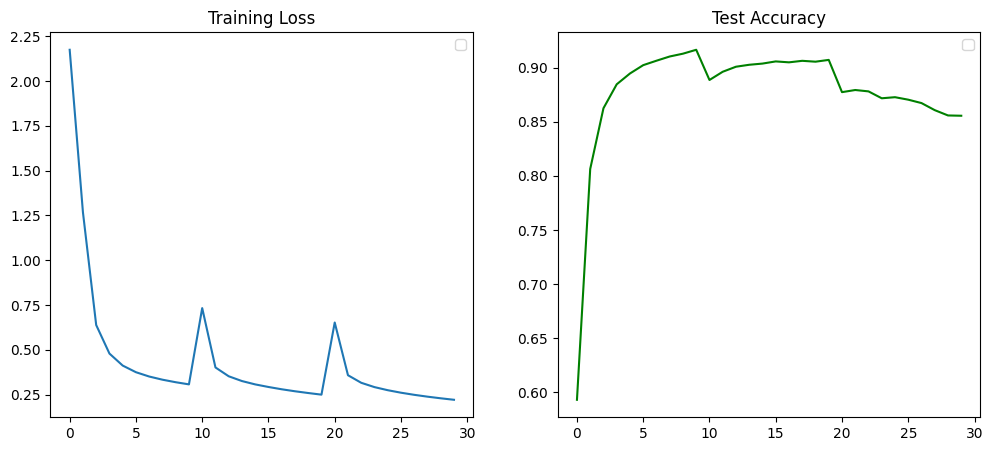

Done!


In [80]:
# Number of tasks and epochs per task
# Type of regularization. Very important for the paper, as it changes the training process
# Type of tasks. We can choose between permuted MNIST and rotated MNIST
N_EPOCHS          = 10
REGULARIZATION    = "SGD" # Possible Values: `SGD`, `L2`, `EWC`
N_TASKS           = 3
DATASET_GENERATOR = generate_permuted_mnist

# Initialize model
model = SmallNet()
model.to(device)

# Loss, optimizer and scheduler
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)

#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=.9)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

print('Training model...')

train_losses = []
test_accuracies = []

test_dataloader = None

for i_task in range(N_TASKS):
    print(f'Training on task {i_task}...')

    # Generate new task
    train_dataloader, partial_test_dataloader = DATASET_GENERATOR(i_task)

    # Combine test_dataloaders
    if test_dataloader == None:
        test_dataloader = partial_test_dataloader
    else:
        test_dataset = torch.utils.data.ConcatDataset([test_dataloader.dataset, partial_test_dataloader.dataset])
        test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Fit on task
    train_losses_task, test_accuracies_task = fit(
        model=model,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        optimizer=optimizer,
        loss_function=F.cross_entropy,
        scheduler=None,
        epochs=N_EPOCHS,
        device=device,
    )

    train_losses += train_losses_task
    test_accuracies += test_accuracies_task

# Save model and curves
torch.save(model.state_dict(), f'{REGULARIZATION}.pt') # not used
np.save(f'{REGULARIZATION}_train_losses.npy', train_losses) # not used
np.save(f'{REGULARIZATION}_test_accuracies.npy', test_accuracies)

# Plot loss as fct of epoch
print('Plotting curves...')
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation losses
axs[0].plot(train_losses)
axs[0].legend()
axs[0].set_title('Training Loss')

# Plot test accuracy
axs[1].plot(test_accuracies, color='green')
axs[1].legend()
axs[1].set_title('Test Accuracy')

plt.show()

print('Done!');

## Generate Figure 2A

Follow these steps to generate figure 2A. You can then redo all these steps after changing the dataset from permuted to rotated MNIST using the option `DATASET_GENERATOR`.
The regularization technique used can be chosen by changing the option `REGULARIZATION`. Each reg technique will save their respective train accuracy curves to different files.

- Run above script with simple cross entropy function (no regularization)
- Run above script with L2 regularization loss function
- Run script above with EWC regularization
- Run the following script which compiles all curves above into one.

In [23]:
FILE_NAMES = [
    "SGD",
    "L2",
    "EWC",
]

for file_name in FILE_NAMES:
    test_accuracies = np.load(f'{file_name}_test_accuracies.npy')
    plt.plot(test_accuracies, label=file_name)

plt.title()
plt.ylabel('Frac. correct')
plt.xlabel('Training time')

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'SGD_test_accuracies.npy'